# Policy Function Iteration, Convergence Criterion, Solvers

Topics:
1. Policy Function Iteration
2. Root-finding with bisection
3. Hill-climbing algorithm

## Policy Function Iteration

In our dynamic programming problem one of the most expensive steps was finding the optimal consumption choice. But, once we find it, we only use the solution once,
$$
V_{n+1}(a) = u(c_n(a)) + \beta V_n((1+r)a + y - c_n(a)).
$$
Then in the next round we compute another policy.

Policy iteration is an improvement-step that repeatedly applies the solution $c_n$ in the Bellman equation before we step into another value function iteration. Denote $V_{n,m}$ the value function after $n$ value function iterations and $m$ policy function iterations. Then,
$$
V_{n,m+1}(a) = u(c_{n}(a)) + \beta V_{n,m}((1+r)a + y - c_n(a)).
$$

This can significantly speed up finding the solution. But there is a cost in that global convergence is no longer guaranteed.

Converged after 128 iterations.


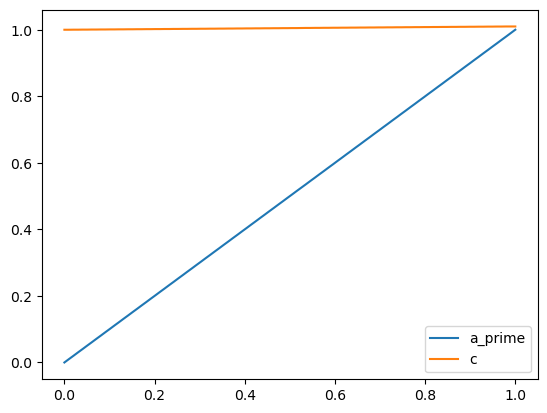

[1.0001001  1.0001001  1.0003003  1.0003003  1.0005005  1.0005005
 1.0007007  1.0007007  1.0009009  1.0009009  1.0011011  1.0011011
 1.0013013  1.0013013  1.0015015  1.0015015  1.0017017  1.0017017
 1.0019019  1.0019019  1.0021021  1.0021021  1.0023023  1.0023023
 1.0025025  1.0025025  1.0027027  1.0027027  1.0029029  1.0029029
 1.0031031  1.0031031  1.0033033  1.0033033  1.0035035  1.0035035
 1.0037037  1.0037037  1.0039039  1.0039039  1.0041041  1.0041041
 1.0043043  1.0043043  1.0045045  1.0045045  1.0047047  1.0047047
 1.0049049  1.0049049  1.00510511 1.00510511 1.00530531 1.00550551
 1.00550551 1.00570571 1.00570571 1.00590591 1.00590591 1.00610611
 1.00610611 1.00630631 1.00630631 1.00650651 1.00650651 1.00670671
 1.00670671 1.00690691 1.00690691 1.00710711 1.00710711 1.00730731
 1.00730731 1.00750751 1.00750751 1.00770771 1.00770771 1.00790791
 1.00790791 1.00810811 1.00810811 1.00830831 1.00830831 1.00850851
 1.00850851 1.00870871 1.00870871 1.00890891 1.00890891 1.00910911
 1.

In [31]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# same setup as before
max_iter = 2000
policy_iter = 10
tolerance = 1e-7
iteration = 0

# fix parameters beta, r, and y
beta = 0.99
r = (1/beta) - 1
y = 1
amin = 0
amax = 1
grid_size = 100

# define asset grid
a = np.linspace(amin, amax, grid_size)

# initial guess for the value function
v0 = np.log(np.linspace(1, 10, grid_size))

# define utility function --- makes it easy to change later
def utility(c):
    return np.log(c)

v_new = v0

# Howard iteration in value function consumption problem
while iteration < max_iter:
    v_old = v_new
    c_candidates = y + np.linspace(-0.1, 0.1, 1000)
    a_prime_candidates = (1+r)*a[np.newaxis, :] + y - c_candidates[:, np.newaxis]
    f_interp = interp1d(a, v_old, kind='linear', bounds_error=False, fill_value='extrapolate')
    v_prime_candidates = f_interp(a_prime_candidates)
    utility_values = utility(c_candidates[:, np.newaxis]) + beta * v_prime_candidates
    c_index = np.argmax(utility_values, axis=0)
    c = c_candidates[c_index]
    v_new = np.max(utility_values, axis=0)

    # howard iteration
    for _ in range(policy_iter):
        a_prime = (1+r)*a + y - c
        f_interp = interp1d(a, v_new, kind='linear', bounds_error=False, fill_value='extrapolate')
        v_new = utility(c) + beta * f_interp(a_prime)

    if np.max(np.abs(v_new - v_old)) < tolerance:
        print(f'Converged after {iteration} iterations.')
        break
    iteration += 1

# plot the value function and the initial guess v0
plt.plot(a, a_prime, label='a_prime')
plt.plot(a, c, label='c')
plt.legend()
plt.show()

print(c)

Another form of policy function iteration iterates directly on the FOC. We know the Euler equation for our model is
\begin{align*}
u'(c(a)) = \beta(1+r)u'(c((1+r)a + y - c(a)))
\end{align*}

We can form a guess $c(a)$ and iterate on the FOC. However, unlike iterating on the value function we generally cannot guarantee convergence. (Why?)

In [2]:
# iterating on the FOC

## Solvers

Rather than iterating on the FOC, we can also view it as a root-finding problem. A root-finding problem can be cast as finding the $x$ such that $f(x)=0$. This means we can use other mathematical tools to find a solution that might be more effective since convergence through iteration is not guaranteed.

The benchmark root-finding method is called bisection. 